*Copyright (c) 2023 Graphcore Ltd. All rights reserved.*

## Evaluation of the auxiliary gamma function

The evaluation of integrals involving a $\frac{1}{r}$ term require computing the following:

$$
F(\nu, t) = \int_0^1 u^{2 \nu} e^{-t u^2} du
$$

Taketa et al. call this the auxiliary function $F$ and we can show its relationship to the $\gamma$ function with SymPy.
First we build up the integral as stated in equation 2.11 in the THO paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *

u, t = symbols("u t", real=True, nonnegative=True)
nu = Symbol("nu", integer=True, nonnegative=True)
F_nu = Integral(u ** (2 * nu) * exp(-t * u **2), (u, 0, 1))
F_nu

Integral(u**(2*nu)*exp(-t*u**2), (u, 0, 1))

Evaluating the integral results in an expression involving the [lower incomplete Gamma function](https://mathworld.wolfram.com/IncompleteGammaFunction.html)

In [2]:
gammanu = simplify(F_nu.doit())
gammanu

t**(-nu - 1/2)*lowergamma(nu + 1/2, t)/2

It is useful to also note the limit as $t\rightarrow 0$

In [3]:
F_nu.subs(t, 0).doit()

1/(2*nu + 1)

Using `lambdify` we can use SymPy to generate a scipy compatible implementation

In [4]:
help(lambdify((nu, t), gammanu, modules="scipy"))

Help on function _lambdifygenerated:

_lambdifygenerated(nu, t)
    Created with lambdify. Signature:
    
    func(nu, t)
    
    Expression:
    
    t**(-nu - 1/2)*lowergamma(nu + 1/2, t)/2
    
    Source code:
    
    def _lambdifygenerated(nu, t):
        return (1/2)*t**(-nu - 1/2)*gamma(nu + 1/2)*gammainc(nu + 1/2, t)
    
    
    Imported modules:



We might need this lambda implementation later but for now let us see if SymPy can find a simpler way to evaluate this function for the integers 0, 1, 2, 3, ...

In [5]:
for i in range(5):
    display(simplify(gammanu.subs(nu, i)))

sqrt(pi)*erf(sqrt(t))/(2*sqrt(t))

-exp(-t)/(2*t) + sqrt(pi)*erf(sqrt(t))/(4*t**(3/2))

-exp(-t)/(2*t) - 3*exp(-t)/(4*t**2) + 3*sqrt(pi)*erf(sqrt(t))/(8*t**(5/2))

(-8*t**(5/2) - 20*t**(3/2) - 30*sqrt(t) + 15*sqrt(pi)*exp(t)*erf(sqrt(t)))*exp(-t)/(16*t**(7/2))

(-16*t**(7/2) - 56*t**(5/2) - 140*t**(3/2) - 210*sqrt(t) + 105*sqrt(pi)*exp(t)*erf(sqrt(t)))*exp(-t)/(32*t**(9/2))

This has a whiff of a recurrence but unfortunately SymPy doesn't seem to find it.  Lets see if we can spot the pattern:

In [6]:
f_0 = simplify(gammanu.subs(nu, 0))
f_0

sqrt(pi)*erf(sqrt(t))/(2*sqrt(t))

In [7]:
f_1 = simplify(1/(2* t) * (f_0 - exp(-t)))
f_1

-exp(-t)/(2*t) + sqrt(pi)*erf(sqrt(t))/(4*t**(3/2))

In [8]:
f_2 = simplify(1 / (2 * t) * (3 * f_1 - exp(-t)))
f_2

-exp(-t)/(2*t) - 3*exp(-t)/(4*t**2) + 3*sqrt(pi)*erf(sqrt(t))/(8*t**(5/2))

In [9]:
f_3 = collect(simplify(1 / (2 * t) * (5 * f_2 - exp(-t))), exp(-t))
f_3

(-1/(2*t) - 5/(4*t**2) - 15/(8*t**3))*exp(-t) + 15*sqrt(pi)*erf(sqrt(t))/(16*t**(7/2))

In [10]:
f_4 = simplify(1 / (2 * t) * (7 * f_3 - exp(-t)))
f_4

(-16*t**(19/2) - 14*t**(13/2)*(4*t**2 + 10*t + 15) + 105*sqrt(pi)*t**6*exp(t)*erf(sqrt(t)))*exp(-t)/(32*t**(21/2))

From this, we propose the following recurrence:

$$
F(0, t) = \frac{1}{2} \text{erf}(\sqrt{t}) \sqrt{\frac{\pi}{t}}
$$

$$
F(\nu, t) = \frac{1}{2 t} \left( (2\nu - 1) F(\nu - 1, t) - e^{-t} \right)
$$

We test this recurrence out by comparing to the earlier lambda implementation derived by SymPy

nu = 0 max error = 3.6637359812630166e-15
nu = 1 max error = 1.942890293094024e-16
nu = 2 max error = 3.3306690738754696e-16
nu = 3 max error = 1.6237011735142914e-15
nu = 4 max error = 1.1310397063368782e-14
nu = 5 max error = 9.851147675377092e-14
nu = 6 max error = 1.0467876565556367e-12
nu = 7 max error = 1.3154359546074801e-11
nu = 8 max error = 1.9073770340938268e-10
nu = 9 max error = 3.1344563958257687e-09


/tmp/ipykernel_3030316/1958191662.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.where(t == 0, 1.0, erf(np.sqrt(t)) * np.sqrt(np.pi / (4 * t)))
/tmp/ipykernel_3030316/1958191662.py:4: RuntimeWarning: invalid value encountered in multiply
  return np.where(t == 0, 1.0, erf(np.sqrt(t)) * np.sqrt(np.pi / (4 * t)))
/tmp/ipykernel_3030316/1958191662.py:18: RuntimeWarning: divide by zero encountered in log
  v = np.exp(np.log(0.5) - (nu + 0.5) * np.log(t) + np.log(gammainc(nu + 0.5, t)) + gammaln(nu + 0.5))
/tmp/ipykernel_3030316/1958191662.py:18: RuntimeWarning: invalid value encountered in add
  v = np.exp(np.log(0.5) - (nu + 0.5) * np.log(t) + np.log(gammainc(nu + 0.5, t)) + gammaln(nu + 0.5))
/tmp/ipykernel_3030316/1958191662.py:11: RuntimeWarning: divide by zero encountered in divide
  v = 1/ (2 * t) * ( (2 * nu - 1) * f_nu(nu-1, t) - np.exp(-t) )
/tmp/ipykernel_3030316/1958191662.py:11: RuntimeWarning: invalid value encountered in multiply
  v = 1/ (2 * t) * ( (

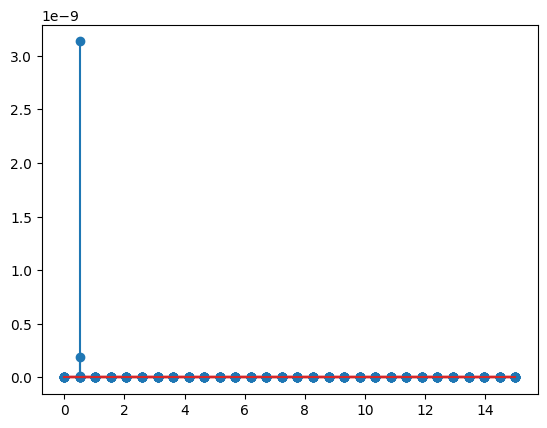

In [11]:
def f_0(t):
    from scipy.special import erf 

    return np.where(t == 0, 1.0, erf(np.sqrt(t)) * np.sqrt(np.pi / (4 * t)))


def f_nu(nu, t, epsilon=1e-10):
    if nu == 0:
        return f_0(t)

    v = 1/ (2 * t) * ( (2 * nu - 1) * f_nu(nu-1, t) - np.exp(-t) )
    return np.where(t <= epsilon, 1 / (2 * nu + 1), v)


def gamma_nu(nu, t, epsilon=1e-10):
    from scipy.special import gammainc, gammaln

    v = np.exp(np.log(0.5) - (nu + 0.5) * np.log(t) + np.log(gammainc(nu + 0.5, t)) + gammaln(nu + 0.5))
    return np.where(t <= epsilon, 1 / (2 * nu + 1), v)
  
x = np.linspace(0, 15, 30)

for n in range(10):
    y1 = f_nu(n, x)
    y2 = gamma_nu(n, x)
    e = np.abs(y1-y2)
    print(f"nu = {n} max error = {e.max()}")
    plt.stem(x, e)

plt.show()


The warnings are ok to ignore since we are evaluating the limit as $t \rightarrow 0$ and otherwise looks ok at least for up to $\nu = 9$ 

## Boost Math

The boost math library contains a comprehensive implementation of the four different different variants of the gamma function.  For consistent definitions we follow their notation repeated here:



1. The lower incomplete gamma function of $a$ and $z$
$$
\gamma(a, z) = \int_0^z t^{a-1} e^{-t} dt
$$ 

2. normalised lower incomplete gamma function of $a$ and $z$.  This definition is consistent with the [scipy.special.gammainc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammainc.html) implementation
$$
P(a, z) = \frac{\gamma(a, z)}{\Gamma(a)} = \frac{1}{\Gamma(a)} \int_0^z t^{a-1} e^{-t} dt
$$

3. upper incomplete gamma function of $a$ and $z$.
$$
\Gamma(a, z) = \int_z^\infty t^{a-1} e^{-t} dt
$$

4. normalised upper incomplete gamma function of $a$ and $z$. This definition is consisent with the [scipy.special.gammaincc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammaincc.html) implementation
$$
Q(a, z) = \frac{\Gamma(a, z)}{\Gamma(a)} = \frac{1}{\Gamma(a)} \int_z^\infty t^{a-1} e^{-t} dt
$$

An additional identiy that follows from the integral definition:
$$
\gamma(a, z) + \Gamma(a, z) = \Gamma(a)
$$
and for the normalised functions we have:
$$
P(a, z) + Q(a, z) = 1
$$

Back to the boost libary, see [#10](https://beta.boost.org/doc/libs/1_82_0/libs/math/doc/html/math_toolkit/sf_gamma/igamma.html#math_toolkit.sf_gamma.igamma.implementation) of their implementation notes which states for half-integers $a \in [\frac{1}{2}, 30]$ that the following series expansion should be used to evaluate the upper incomplete regularised gamma function:
$$
Q(a, x) = \text{erfc}(\sqrt{x}) + \frac{e^{-x}}{\sqrt{\pi x}} \sum_{n=1}^{a - \frac{1}{2}} \frac{x^n}{(1 - \frac{1}{2}) \cdots (n - \frac{1}{2})}
$$




In [12]:
def g(a, x):
    from scipy.special import erfc, gamma

    term = np.exp(-x) / np.sqrt(np.pi * x)
    q = erfc(np.sqrt(x))

    for n in range(1, int(a+0.5)):
        term /= n - 0.5
        term *= x
        q += term

    return (1 - q) * gamma(a)

def gv(a, x, amax=30):
    from scipy.special import erfc, gamma

    n = np.arange(1, amax+1)
    mask = n <= a
    q = erfc(np.sqrt(x))
    q += np.exp(-x) / np.sqrt(np.pi * x) * np.sum(mask * x ** n / np.cumprod(n-0.5))

    return (1 - q) * gamma(a)

def og(a, x):
    from scipy.special import gammainc, gamma, gammaln

    return np.exp(gammaln(a) + np.log(gammainc(a, x)))
    
def pq(a, x):
    from pyquante2.utils import gamm_inc

    return gamm_inc(a, x)

x = 1.0
for a in range(20):
    abs_error = np.abs(og(a+0.5, x) - g(a+0.5, x))
    rel_error = abs_error / og(a+0.5, x)
    print(abs_error, rel_error)


6.661338147750939e-16 4.459776977656937e-16
1.6653345369377348e-16 4.3946638485055916e-16
2.220446049250313e-16 1.107246765857766e-15
4.163336342344337e-16 3.1194323558338866e-15
2.2620794126737565e-15 2.2792539957273192e-14
1.2420620087993939e-14 1.5776276943287004e-13
6.49896803039951e-14 9.977832158152448e-13
3.554517791215517e-13 6.405459416834582e-12
2.5983729057266203e-12 5.3784749837562836e-11
1.7344348179904046e-11 4.0561555937670355e-10
1.4016347804624019e-10 3.6552429262447314e-09
1.069651311969011e-09 3.077936926389166e-08
1.255947506412225e-08 3.9531191153418467e-07
9.648126094580212e-08 3.2975236827047864e-06
1.2419848460266947e-06 4.580767701633588e-05
1.7948268090407782e-05 0.0007105560037904496
1.7915769273919163e-05 0.0007577831080872898
0.0032044584860772968 0.14421996957159758
0.020957303649203077 1.0
0.01983067633881408 1.0


## Series evaluation of lower incomplete gamma function

The special case above appears to have excessive errors as `a` increases. We can instead try the standard series expansion method:
$$
\gamma(a, z) = z^a e^{-z} \sum_{k=0}^{\infty} \frac{\Gamma(a)}{\Gamma(a + k + 1)} z^k
$$
See [#4](https://beta.boost.org/doc/libs/1_82_0/libs/math/doc/html/math_toolkit/sf_gamma/igamma.html#math_toolkit.sf_gamma.igamma.implementation) on the boost documentation which also shows how this series can be simplfied to:
$$
\gamma(a, z) = z^a e^{-z} \sum_{k=0}^{\infty} \frac{z^k}{a^{k+1}}
$$
by using the recursion relation:
$$
\Gamma(z+1) = z \Gamma(z)
$$
This can be used to build a log-space implementation of the lower incomplete gamma function.

In [44]:
def gammaincln_loop(a: float, z: float, num_terms=32, epsilon=1e-10):
    """Lower incomplete gamma function computed from its series representation in log-space

    Should be equivalent to:

        import numpy as np
        from scipy.special import gammainc, gammaln

        gammaln(a) + np.log(gammainc(a, z))
    """
    a0 = a
    term = 1 / a
    total = 0.0

    for _ in range(num_terms):
        a += 1
        term *= z / a
        total += term

    total += 1 / a0
    z = max(z, epsilon)
    return a0 * np.log(z) - z + np.log(total)


def gammaincln_vec(a, z, num_terms=32, epsilon=1e-10):
    k = np.arange(1, num_terms)
    terms = np.insert(z / (a + k), 0, 1 / a)
    total = np.sum(np.cumprod(terms))
    z = np.maximum(z, epsilon)
    return a * np.log(z) - z + np.log(total)


gammaincln = gammaincln_vec


def reference_scipy(a, z):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammainc.html
    from scipy.special import gammaln, gammainc

    return gammaln(a) + np.log(gammainc(a, z))


def reference_mpmath(a, z):
    # https://mpmath.org/doc/current/functions/expintegrals.html#gammainc
    from mpmath import gammainc, log

    return float(log(gammainc(float(a), b=float(z))))


a = 1.5
z = 10.0

ref_sp = reference_scipy(a, z)
ref_mp = reference_mpmath(a, z)
ans = gammaincln(a, z, 64)
abs((ref_sp - ans) / ref_sp), abs((ref_mp - ans) / ref_mp)

(3.327401488179459e-15, 3.556877452881491e-15)

How many terms need to be evaluated to converge?

In [45]:
import pandas as pd

A = np.arange(0, 16, 4) + 0.5
Z = np.linspace(0, 20, 5)
N = np.array([16, 32, 64])

vals = np.meshgrid(A, Z, N)
A, Z, N = [t.reshape(-1) for t in vals]

actual = np.vectorize(gammaincln)(A, Z, N)
expect = reference_scipy(A, np.maximum(Z, 1e-10))

df = pd.DataFrame({"a": A, "z": Z, "num_terms": N, "actual": actual, "expect": expect})
df["rel_error"] = np.abs((df.actual - df.expect) / df.expect)
df["abs_error"] = np.abs(df.actual - df.expect)

df.head()

,a,z,num_terms,actual,expect,rel_error,abs_error
0,0.5,0.0,16,-10.819778,-10.819778,6.161556e-12,6.666667e-11
1,0.5,0.0,32,-10.819778,-10.819778,6.161556e-12,6.666667e-11
2,0.5,0.0,64,-10.819778,-10.819778,6.161556e-12,6.666667e-11
3,4.5,0.0,16,-105.120407,-105.120407,1.729035e-13,1.817568e-11
4,4.5,0.0,32,-105.120407,-105.120407,1.729035e-13,1.817568e-11


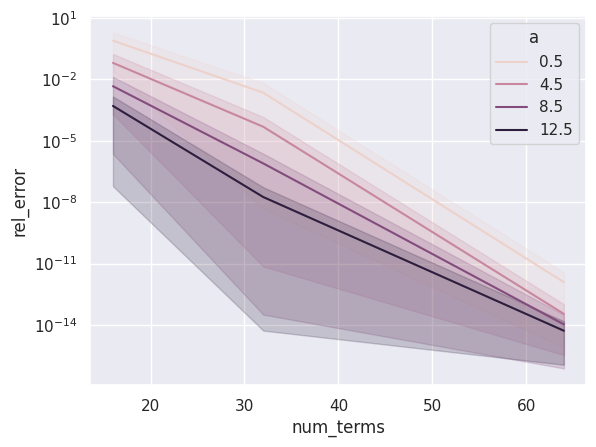

In [46]:
import seaborn as sns
sns.set_theme()

sns.lineplot(data=df, x="num_terms", y="rel_error", hue="a")
plt.yscale("log")

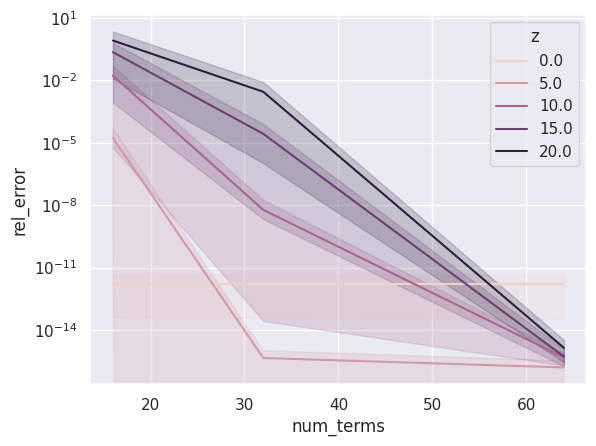

In [47]:
sns.lineplot(data=df, x="num_terms", y="rel_error", hue="z")
plt.yscale("log")

In [36]:
a = 1.0
z = 1.0
k = np.arange(0, 16)
total = np.sum(np.cumprod(z / (a + k)))
a * np.log(z) - z + np.log(total)

-0.45867514538708354

0.7182787698412697